<a href="https://colab.research.google.com/github/johanhoffman/DD2365-VT20/blob/LindeBee/Project/projectV4_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Part II: Transport Function**
**Linde van Beers**

In [32]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

**Set up environment**

In [0]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common 
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import dolfin.common.plotting as fenicsplot
import math
import scipy.io

from matplotlib import pyplot as plt

**Import mesh and define evaluation area**

2390


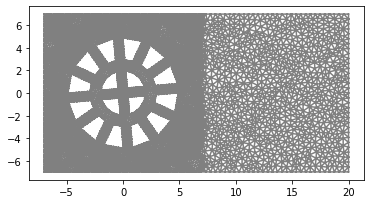

In [34]:
!rm results/*

# Define rectangular domain 
L = 14
H = 14

# import mesh
resolution = 64
mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh_file = File('mesh.xml')
mesh_file >> mesh

# define source/evaluation area
class SourceGrid(SubDomain):
    def inside(self, x, on_boundary):
        return (x[1]<5.07/cos(alpha) + tan(alpha)*x[0] \
                and x[1]>-5.07/cos(alpha) + tan(alpha)*x[0] \
                and x[0]<5.07/cos(alpha) - tan(alpha)*x[1] and \
                x[0]>-5.07/cos(alpha) - tan(alpha)*x[1])

class SourceSkewed(SubDomain):
    def inside(self, x, on_boundary):
        return (x[1]<4.8/cos(alpha) + tan(alpha)*x[0] \
                and x[1]>-4.7/cos(alpha) + tan(alpha)*x[0] \
                and x[0]<5.3/cos(alpha) - tan(alpha)*x[1] and \
                x[0]>-4.9/cos(alpha) - tan(alpha)*x[1])

class SourceCircle(SubDomain):
    def inside(self, x, on_boundary):
        return (sqrt(x[0]*x[0]+x[1]*x[1])< 5.5)

alpha = math.radians(0)
# source = SourceGrid()
# source = SourceSkewed()
source = SourceCircle()

domains = MeshFunction("size_t", mesh, mesh.topology().dim())
domains.set_all(0)
source.mark(domains, 1)
cells = domains.array()
n_cells = np.count_nonzero(cells == 1)
print(n_cells)

# for visualisation of different domains
file = File("results/mesh.pvd")
file << domains

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [0]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions 
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

**Define boundary conditions**

In [0]:
# # inflow and outflow conditions
XMIN = -7

# Inflow boundary (ib)
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())

**Time stepping algorithm**

In [37]:
# Define function space for system of concentrations
u = Function(V)
element = FiniteElement("P", triangle, 1)
Vc = FunctionSpace(mesh, element)
c = Function(Vc)
c_n = Function(Vc)
vc = TestFunction(Vc) #test function
# introduce concentration of 1 per second
# cin = (0.1/n_cells)*42.6
# cin = (0.1/n_cells)*44.7
cin = (0.1/n_cells)
# circle
fc = Expression( "sqrt(x[0]*x[0]+x[1]*x[1])< 5.5 ? cin : 0", cin=cin , element = Vc.ufl_element()) #source
# grid
# fc = Expression( "(x[1]<5.07/cos(alpha) + tan(alpha)*x[0] && x[1]>-5.07/cos(alpha) + tan(alpha)*x[0] && x[0]<5.07/cos(alpha) - tan(alpha)*x[1] && x[0]>-5.07/cos(alpha) - tan(alpha)*x[1]) ? cin : 0", \
#                cin=cin, alpha=alpha ,element = Vc.ufl_element()) #source
# skewed
# fc = Expression( "(x[1]<4.8/cos(alpha) + tan(alpha)*x[0] && x[1]>-4.7/cos(alpha) + tan(alpha)*x[0] && x[0]<5.3/cos(alpha) - tan(alpha)*x[1] && x[0]>-4.9/cos(alpha) - tan(alpha)*x[1]) ? cin : 0", \
#                 cin=cin, alpha=alpha ,element = Vc.ufl_element()) #source

dt = 0.5*mesh.hmin()  #time step
print(dt)
d = mesh.hmin()
dx=Measure('dx', domain=mesh, subdomain_data=domains)

h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

#variational problem:
Fc = inner((c-c_n)/dt,vc)*dx + inner(dot(u,grad(c)),vc)*dx \
+ gamma*ib*inner(c,vc)*dx + d*dot(u,grad(c))*dot(u,grad(vc))*dx - fc*vc*dx

0.06119345163291075


In [38]:
# normLIStion
t=0
T=5
while t < T + DOLFIN_EPS:
    # print(n+"\n")
    # Update current time
    t += dt
    # Solve variational problem for time step
    solve(Fc == 0, c)
    # truncate negative values
    Cvector = as_backend_type(c.vector()).get_local()
    Cvector[Cvector<0] = 0.0
    c.vector().set_local(Cvector)
    
    # Update previous solution
    c_n.assign(c)

c_val = assemble(c*dx(1))
nor = (t/10)/c_val
print(nor)

# reinitialise with new cin
c = Function(Vc)
c_n = Function(Vc)
cin = cin*nor
# circle
fc = Expression( "sqrt(x[0]*x[0]+x[1]*x[1])< 5.5 ? cin : 0", cin=cin , element = Vc.ufl_element()) #source
# grid
# fc = Expression( "(x[1]<5.07/cos(alpha) + tan(alpha)*x[0] && x[1]>-5.07/cos(alpha) + tan(alpha)*x[0] && x[0]<5.07/cos(alpha) - tan(alpha)*x[1] && x[0]>-5.07/cos(alpha) - tan(alpha)*x[1]) ? cin : 0", \
#                 cin=cin, alpha=alpha ,element = Vc.ufl_element()) #source
# skewed
# fc = Expression( "(x[1]<4.8/cos(alpha) + tan(alpha)*x[0] && x[1]>-4.7/cos(alpha) + tan(alpha)*x[0] && x[0]<5.3/cos(alpha) - tan(alpha)*x[1] && x[0]>-4.9/cos(alpha) - tan(alpha)*x[1]) ? cin : 0", \
#                 cin=cin, alpha=alpha ,element = Vc.ufl_element()) #source

Fc = inner((c-c_n)/dt,vc)*dx + inner(dot(u,grad(c)),vc)*dx \
+ gamma*ib*inner(c,vc)*dx + d*dot(u,grad(c))*dot(u,grad(vc))*dx - fc*vc*dx

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
43.05594562824349


t: 1.0402886777594829
c: 0.09852995628324729
t: 2.019383903886054
c: 0.18067510065475473
t: 3.0596725816455392
c: 0.2585124884718667
t: 4.038767807772113
c: 0.3243919112495958
t: 5.017863033898688
c: 0.3846863300766675
t: 6.058151711658173
c: 0.4452955689875773
t: 7.037246937784747
c: 0.4944139618968914
t: 8.016342163911322
c: 0.53929642831736
t: 9.056630841670792
c: 0.5842034704093744
t: 10.035726067797352
c: 0.6240559664029198
t: 11.014821293923912
c: 0.6644713944981857
t: 12.055109971683382
c: 0.7010294615164959
t: 13.034205197809943
c: 0.7315084026887606
t: 14.013300423936503
c: 0.7609846973796901
t: 15.053589101695973
c: 0.7918877201108033
t: 16.032684327822533
c: 0.8230850463471757
t: 17.011779553949093
c: 0.8490554604150272
t: 18.052068231708564
c: 0.872628603811095
t: 19.031163457835124
c: 0.8945300281010781
t: 20.010258683961684
c: 0.9171371258647706
t: 21.050547361721154
c: 0.944011043459497
t: 22.029642587847714
c: 0.9639518008107252
t: 23.008737813974275
c: 0.98061847113228

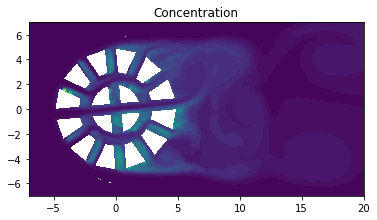

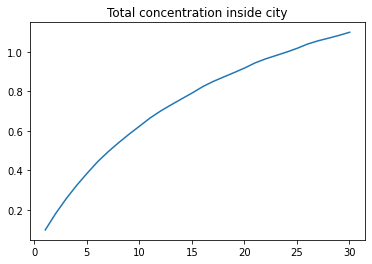

In [39]:
#time stepping
# file_c = File("results/c.pvd")
# file_u = File("results/u.pvd")
timeseries_u = TimeSeries('velocity_series')

t=0
T=30
freq = 30
plot_time = T/freq

c_plot= []
time =[]

while t < T + DOLFIN_EPS:
    # print(n+"\n")
    # Update current time
    t += dt
    # get velocity field
    timeseries_u.retrieve(u.vector(), t%5)
    # Solve variational problem for time step
    solve(Fc == 0, c)
    # truncate negative values
    Cvector = as_backend_type(c.vector()).get_local()
    Cvector[Cvector<0] = 0.0
    c.vector().set_local(Cvector)
    
    # Update previous solution
    c_n.assign(c)

    if t > plot_time: 
      c_val = assemble(c*dx(1))
      c_plot = np.append(c_plot,c_val)
      time = np.append(time,t)
      print('t:',t)
      print('c:', c_val)
      # Save solution to file (VTK)
      # file_c << (c, t)
      # file_u << (u, t)
      plot_time += T/freq
      # c1 = project(c, Vc)
      # plt.figure()
      # plot(c1, title="Concentration")
      # plt.show()
      
# Plot solution
print('t:',t)
print('c:', c_val)

c1 = project(c, Vc)
plt.figure()
plot(c1, title="Concentration")
plt.show()

plt.figure()
plt.plot(time, c_plot)
plt.title("Total concentration inside city")
plt.show()

arr = np.append(np.matrix(time), np.matrix(c_plot),axis =0).T
scipy.io.savemat('results/arrdata.mat', mdict={'arr': arr})

# !tar -czvf results.tar.gz results
files.download('results/arrdata.mat')